## Animating the irrigated area shapefiles

The animation will include a lineplot with irrigated area anomalies and winter rainfall anomalies alongside.

The animation uses a small subset of the NMDB because the files are too large otherwise. 


In [1]:
# Import modules
import sys
import os
import pandas as pd
import geopandas as gpd
from IPython.display import Image
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from osgeo import gdal, ogr

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('src/')
import DEADataHandling
import DEAPlotting
from SpatialTools import geotransform
from SpatialTools import array_to_geotiff
from SpatialTools import rasterize_vector

### User Inputs

In [2]:
#Pandas plot files
irr_file = 'results/nmdb_plots/csvs/NMDB_annual_area.csv'
# rain_file = 'data/mdb_rainfall.csv'
rain_file = 'results/nmdb_winterRainAnoms.csv'

#Animation files
# data = "results/animations/NMDB_irrigation.nc"
data = "results/animations/threeRivers_irrigation.nc"

directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
suffix = "_Irrigated_OEHandLS_masked"

nmdb_shape = "data/spatial/northern_basins.shp"
threeRivers = 'data/spatial/ThreeRivers.shp'

### Firstly, lets get our pandas dataframe sorted

In [3]:
#get our irrigated area data, and scale it so numbers are similar to rainfall anomalies
irr_area = pd.read_csv(irr_file)['irrigated area']
mean_area = irr_area.mean()
irr_anom = irr_area - mean_area
scaledIrrAreaAnom = irr_anom / 1000

#load in rainfall anomaly data
rain = pd.read_csv(rain_file)
rain = rain.drop([24,25])

dates = pd.date_range(start='1/1/1987', end='1/01/2019', freq='Y')
dates = dates.drop([pd.Timestamp('2011-12-31'), pd.Timestamp('2012-12-31')])

In [4]:
df = pd.DataFrame({"Rainfall (mm)": list(rain.rainfall),
                   "Irrigation (10^3 Ha)": list(scaledIrrAreaAnom)}, 
                    index =dates)

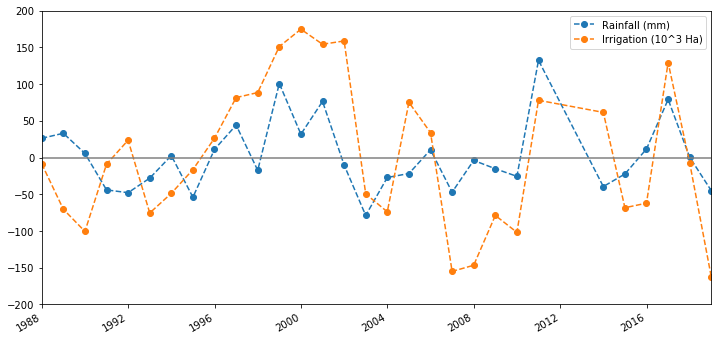

In [5]:
df.plot(figsize=(12,6),ylim=(-200,200), style='o--')
plt.axhline(y=0,c= 'grey', linestyle='-')

### Now, lets get the irrigated area shapefiles into an xarray

In [ ]:
#list of years to help for-loop iterate through folders
x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

#list of folders to help with loop
folders = os.listdir(directory)
folders.sort()

In [ ]:
# Convert our shapefiles into tiffs, add them to an giant xarray and 
# then export as netcdf so we don't have to keep loading them while we
# work out the animation code.
def convertIrrShpToTiff(shp, year):  
    #open a tif and get transform info
    tif = shp[:77]+shp[77:95]+"_multithreshold_65Thres"+suffix[10:]+".tif"
    ds = xr.open_rasterio(tif).squeeze()
    transform, proj = geotransform(ds, (ds.x, ds.y), epsg=3577, alignment='centre')
    rows,cols = ds.shape
    #turn vector in numpy array
    shp_arr = rasterize_vector(shp, cols=cols, rows=rows, geo_transform=transform, projection=proj)
    #convert numpy array inot xarray
    shp_xr = xr.DataArray(shp_arr, coords = [ds.y, ds.x], dims = ['y', 'x'])
    #append xarray to list
    da_list.append(shp_xr)

da_list = []
for year, folder in zip(years, folders): 
    print("\r", "working on year: " + year, end = '')
    convertIrrShpToTiff(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp", year)

#generate date ranges to use as cooridnates in xrray dataset
dates = pd.date_range(start='1/1/1987', end='1/01/2019', freq='Y')
dates = dates.drop([pd.Timestamp('2011-12-31'), pd.Timestamp('2012-12-31')])
#concatenate all xarrays in list to a single multi-dim xarray with time ('dates') as coords.
da = xr.concat(da_list, dim=dates).rename({'concat_dim':'time'}).rename('Irrigated_Area')
#convert to dataset
ds = da.to_dataset()
#export netcdf
ds.to_netcdf("results/animations/NMDB_irrigation.nc")

### Now, load in xarray dataset of the irrigated areas and animate with lineplot

In [9]:
ds = xr.open_dataset(data).isel(x=range(6000,9000)).isel(y=range(9500,12000))
#NOTE: can't have nans in the dataset or the animnation will be blank
# ds = ds.fillna(0.01)

In [12]:
ds

<xarray.Dataset>
Dimensions:         (time: 30, x: 3000, y: 2500)
Coordinates:
  * y               (y) float64 -3.359e+06 -3.359e+06 ... -3.421e+06 -3.421e+06
  * x               (x) float64 1.613e+06 1.613e+06 ... 1.688e+06 1.688e+06
  * time            (time) datetime64[ns] 1987-12-31 1988-12-31 ... 2018-12-31
Data variables:
    Irrigated_Area  (time, y, x) float64 ...

In [13]:
# ds.Irrigated_Area.plot(figsize=(10,6), cmap='cividis',vmin=60)

    Exporting animation to results/test.gif


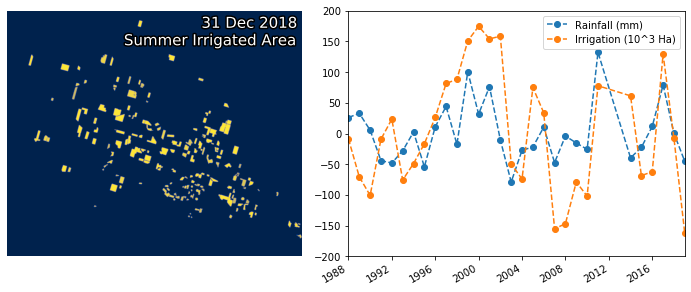

In [14]:
DEAPlotting.animated_timeseriesline(ds, df, "results/test.gif", 
                                    width_pixels=1000, interval=300, bands=['Irrigated_Area'],onebandplot_cbar=False,
                                    show_date=True,title= "Summer Irrigated Area",
                                    onebandplot_kwargs={'cmap':'cividis'},
                                    pandasplot_kwargs={'ylim': (-200,200), 'style':'o--'}, 
                                    )